In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import numpy as np

import h5py

In [4]:
datafolder = '../dataset/'

In [5]:
df = pd.read_csv(datafolder+'dataset.pd', index_col=0)

In [6]:
df.head()

,finger,surface,class,filename
0,index,S3,touch,antoine_2017-03-08_10:48:36.hdf5
1,index,S3,notouch,antoine_2017-03-08_10:50:27.hdf5
2,thumb,S3,touch,antoine_2017-03-08_10:52:53.hdf5
3,thumb,S3,notouch,antoine_2017-03-08_10:54:12.hdf5
4,pinky,S3,touch,antoine_2017-03-08_10:55:51.hdf5


In [7]:
hdf5file = h5py.File(datafolder+df.loc[0, 'filename'], 'r')

In [8]:
d0 = hdf5file['data/depth'][0]

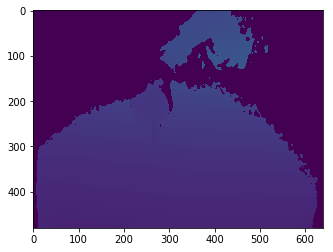

In [9]:
plt.imshow(d0)

In [10]:
from pyrealsense import offline
offline.load_depth_intrinsics('610205001689')

In [11]:
%timeit pc = offline.deproject_depth(d0)

2.86 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
pc = offline.deproject_depth(d0)

In [13]:
import pyrealsense2 as rs

# deproject

## fill intrinsics

In [14]:
import yaml

In [15]:
with open('sr300_610205001689.param', 'r') as fh:
    d = yaml.load(fh)
intr_ = d['610205001689']

In [16]:
intr_

{'coeffs': [0.14429353177547455,
  0.05476438254117966,
  0.004519885405898094,
  0.002106300089508295,
  0.10783065110445023],
 'depth_scale': 0.00012498664727900177,
 'fx': 475.529052734375,
 'fy': 475.5289306640625,
 'height': 480,
 'model': 2,
 'ppx': 314.79681396484375,
 'ppy': 245.8909912109375,
 'width': 640}

In [17]:
intr = rs.intrinsics()

In [18]:
intr.coeffs = intr_['coeffs']
intr.width  = intr_['width']
intr.height = intr_['height']
intr.ppx    = intr_['ppx']
intr.ppy    = intr_['ppy']
intr.fx     = intr_['fx']
intr.fy     = intr_['fy']
# intr.model  = intr_['model']
intr.coeffs = intr_['coeffs']

ds = intr_['depth_scale']

## compute

In [19]:
def deproject_depth_py(depth_image, intr, depth_scale):
    pointcloud = np.zeros((intr.height, intr.width, 3), dtype=np.float32)
    for dy in range(intr.height):
        for dx in range(intr.width):
            depth_value = depth_image[dy, dx] * depth_scale
            if depth_value == 0: continue
            pointcloud[dy, dx] = rs.rs2_deproject_pixel_to_point(intr, [dx, dy], depth_value)
    return pointcloud

In [20]:
%timeit deproject_depth_py(d0, intr, ds)

3.68 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
pc_py = deproject_depth_py(d0, intr, ds)

In [22]:
%load_ext cython

In [106]:
%%cython --annotate
import numpy as np
cimport numpy as np
import pyrealsense2 as rs

DTYPE = np.float32
ctypedef np.float32_t DTYPE_t

def deproject_depth_cy(short[:,:]depth_image, intr, double depth_scale):
    
    cdef int height = intr.height
    cdef int width  = intr.width
    cdef int dx, dy
    cdef float depth_value
    
    cdef np.ndarray[DTYPE_t, ndim=3] pointcloud = np.zeros((height, width, 3), dtype=np.float32)
    
    cdef res = []
    cdef np.ndarray[DTYPE_t, ndim=1] point = np.zeros(3, dtype=np.float32)
    
    cdef float x,y, r2, f, ux, uy
    cdef float ppx, ppy, fx, fy, c0, c1, c2, c3, c4
    
    ppx = intr.ppx
    ppy = intr.ppy
    fx  = intr.fx
    fy  = intr.fy
    c0  = intr.coeffs[0]
    c1  = intr.coeffs[1]
    c2  = intr.coeffs[2]
    c3  = intr.coeffs[3]
    c4  = intr.coeffs[4]
    
    for dy in range(height):
        for dx in range(width):
            depth_value = depth_image[dy, dx] * depth_scale
            if depth_value == 0: continue

            x = (dx - ppx) / fx;
            y = (dy - ppy) / fy;
            r2  = x*x + y*y;
            f = 1 + c0*r2 + c1*r2*r2 + c4*r2*r2*r2;
            ux = x*f + 2*c2*x*y + c3*(r2 + 2*x*x);
            uy = y*f + 2*c3*x*y + c2*(r2 + 2*y*y);
            
            x = ux;
            y = uy;
#             point[0] = depth_value * x;
#             point[1] = depth_value * y;
#             point[2] = depth_value;
#             for i in range(3):
#                 pointcloud[dy, dx, i] = point[i]
            
            pointcloud[dy, dx, 0] = depth_value * x;
            pointcloud[dy, dx, 1] = depth_value * y;
            pointcloud[dy, dx, 2] = depth_value;

    
    return pointcloud

In [107]:
%timeit np.asanyarray(deproject_depth_cy(d0, intr, ds))

3.81 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
pc_cy = np.asanyarray(deproject_depth_cy(d0, intr, ds))

In [77]:
np.all(pc_py == pc_cy)

False

In [30]:
rs.rs2_deproject_pixel_to_point?

In [78]:
import vtkplot

In [83]:
vtkplot.plot_objects(pc_py, pc_cy, axis=True)

/Users/antoine/anaconda/envs/fistwriter_reprod/lib/python3.5/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [ ]:
# def deproject_depth_cy(short[:,:]depth_image, intr, double depth_scale):
    
#     cdef int height = intr.height
#     cdef int width  = intr.width
#     cdef int dx, dy
#     cdef float depth_value
    
#     cdef np.ndarray[DTYPE_t, ndim=3] pointcloud = np.zeros((height, width, 3), dtype=np.float32)
    
#     cdef res = []
    
#     for dy in range(height):
#         for dx in range(width):
#             depth_value = depth_image[dy, dx] * depth_scale
#             if depth_value == 0: continue
#             res = rs.rs2_deproject_pixel_to_point(intr, [dx, dy], depth_value)
#             for i in range(3): pointcloud[dy, dx, i] = res[i]
#     return pointcloud

In [29]:
# def deproject_depth(depth):
#     global depth_intrinsics, depth_scale
#     width = depth_intrinsics.width
#     height = depth_intrinsics.height
#     pointcloud = np.zeros((height * width * 3), dtype=np.float32)
#     rsutilwrapper.deproject_depth(pointcloud, depth_intrinsics, depth, depth_scale)
#     return pointcloud.reshape((height, width, 3))


# void _deproject_depth(float pointcloud[],
#                       const struct rs_intrinsics * intrin,
#                       const uint16_t depth_image[],
#                       const float depth_scale)
# {
#     int dx, dy;
#     for(dy=0; dy<intrin->height; ++dy)
#     {
#         for(dx=0; dx<intrin->width; ++dx)
#         {
#             /* Retrieve the 16-bit depth value and map it into a depth in meters */
#             uint16_t depth_value = ((uint16_t*)depth_image)[dy * intrin->width + dx];
#             float depth_in_meters = depth_value * depth_scale;
#             /* Skip over pixels with a depth value of zero, which is used to indicate no data */
#             if(depth_value == 0) continue;
#             /* Map from pixel coordinates in the depth image to pixel coordinates in the color image */
#             float depth_pixel[2] = {(float)dx, (float)dy};
#             float depth_point[3];
#             rs_deproject_pixel_to_point(depth_point, intrin, depth_pixel, depth_in_meters);
#             /* store a vertex at the 3D location of this depth pixel */
#             pointcloud[dy*intrin->width*3 + dx*3 + 0] = depth_point[0];
#             pointcloud[dy*intrin->width*3 + dx*3 + 1] = depth_point[1];
#             pointcloud[dy*intrin->width*3 + dx*3 + 2] = depth_point[2];
#         }
#     }
# }